In [1]:
import pandas as pd
import numpy as np
import torch as pt
import tqdm
from scipy.linalg import qr
import matplotlib.pyplot as plt
%matplotlib inline

#pt.set_default_tensor_type('torch.FloatTensor')
pt.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
from ml_lib.controllers.Controller import Controller as Control
from ml_lib.clusters.DataCluster import DataCluster as Data
from ml_lib.clusters.LearnCluster import LearnCluster as Learn
from ml_lib.clusters.MergeCluster import MergeCluster as Merge

In [3]:
from ml_lib.utils.learn_modules.learners.GradientLearner import GradientLearner
from ml_lib.utils.learn_modules.learners.NewtonLearner import NewtonLearner
from ml_lib.utils.learn_modules.learners.MomentumLearner import MomentumLearner
from ml_lib.utils.learn_modules.learners.SmoothLearner import SmoothLearner

from ml_lib.utils.learn_modules.activators.LinearActivate import LinearActivate
from ml_lib.utils.learn_modules.activators.SigmoidActivate import SigmoidActivate
from ml_lib.utils.learn_modules.activators.TanhActivator import TanhActivator
from ml_lib.utils.learn_modules.activators.ReluActivator import ReluActivator

In [4]:
dataset = pd.read_csv(
    'data_files/kc_house_data.csv',
    index_col = 'id', parse_dates = ['date'], date_parser = lambda x: pd.datetime.strptime(x, '%Y%m%dT%H%M%S')
)
dataset = dataset[[col for col in dataset.columns if not col.endswith('15')]]
feature_cols = ['sqft_living', 'bedrooms', 'bathrooms']
target_cols = ['price']
dataset[target_cols] = np.log(dataset[target_cols])

In [5]:
verbose = False

learner = SmoothLearner
learner_kwargs = {
    'learn_rate': 1e-1
}

loss_kwargs = {}

nesterov = True

activator = ReluActivator
activator_kwargs = {
    'leak': 0.1
}

batcher_kwargs = {
    'proportion': 1.0
}

control = Control(
    'regression_controller',
    loss_smooth_coefs = [0.9, 100]
)

control.add_cluster(
    Data(
        'data_cluster',
        dataset[feature_cols + target_cols],
        splitter_kwargs = {'verbose': verbose},
        batcher_kwargs = {'verbose': verbose, **batcher_kwargs},
        loss_kwargs = {'verbose': verbose, **loss_kwargs},
        loss_combiner_kwargs = {'verbose': verbose},
        verbose = verbose
    )
)

control.link_add(
    Learn(
        'learn_cluster_1',
        module_kwargs = {
            'nodes': 128,
            'verbose': verbose, 'nesterov': nesterov,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator': activator, 'activator_kwargs': {'verbose': verbose, **activator_kwargs},
            'learner': learner, 'learner_kwargs': {'verbose': verbose, **learner_kwargs}
        },
        verbose = verbose
    ),
    'data_cluster', 'input', data_cols = feature_cols
)

control.link_add(
    Learn(
        'learn_cluster_2',
        module_kwargs = {
            'nodes': 32,
            'verbose': verbose, 'nesterov': nesterov,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator': activator, 'activator_kwargs': {'verbose': verbose, **activator_kwargs},
            'learner': learner, 'learner_kwargs': {'verbose': verbose, **learner_kwargs}
        },
        verbose = verbose
    ),
    'learn_cluster_1', 'input'
)

control.link_add(
    Learn(
        'learn_cluster_out',
        module_kwargs = {
            'nodes': len(target_cols),
            'verbose': verbose, 'nesterov': nesterov,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator_kwargs': {'verbose': verbose},
            'learner': learner, 'learner_kwargs': {'verbose': verbose, **learner_kwargs}
        },
        verbose = verbose
    ),
    'learn_cluster_2', 'input'
)

control.link_clusters('learn_cluster_out', 'data_cluster', data_cols = target_cols)

control.enable_network()

In [6]:
control.train_model(1000)

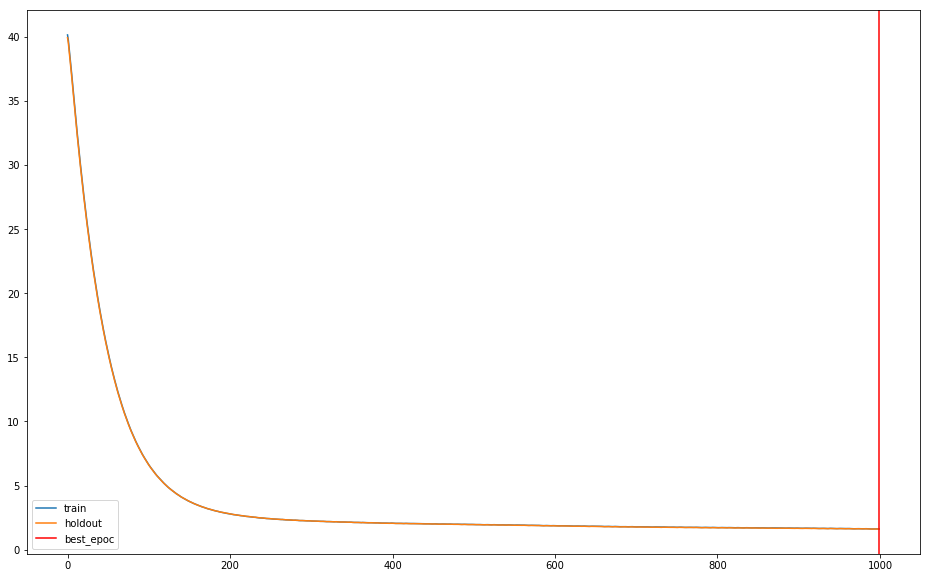

In [7]:
control.plot_losses()

In [8]:
control.predict({'data_cluster': dataset[feature_cols + target_cols]})

{'outputs': {'learn_cluster_1': array([[ 1.41437340e+00, -1.06785633e-01,  6.84319496e-01, ...,
           5.89498460e-01, -6.17749356e-02,  5.11731243e+00],
         [-1.49178132e-01,  1.53793752e-01, -2.85070181e-01, ...,
           1.27010152e-01,  2.28657901e-01, -1.10154964e-01],
         [ 6.25745535e-01,  4.83110547e-03, -5.24500618e-03, ...,
           1.65956473e+00, -1.08808592e-01,  7.36260462e+00],
         ...,
         [ 5.56303978e-01, -2.77754646e-02, -2.76465416e-02, ...,
           1.68972087e+00, -5.67243770e-02,  7.27404356e+00],
         [-5.35059087e-02,  4.88546431e-01, -1.35711387e-01, ...,
           1.81865051e-01, -1.23326220e-01,  8.03829610e-01],
         [ 5.56303978e-01, -2.77754646e-02, -2.76465416e-02, ...,
           1.68972087e+00, -5.67243770e-02,  7.27404356e+00]], dtype=float32),
  'learn_cluster_2': array([[-0.71834147, -0.63287395,  1.1206533 , ..., 13.94851   ,
          -0.9635834 , 13.665463  ],
         [ 3.7261927 ,  6.5689974 , -0.82678694,

In [9]:
control.network_coefs()

{'learn_cluster_1': tensor([[-2.7889e-01, -3.4055e-01, -1.3279e+00,  4.3577e-01,  2.8073e-02,
          -1.0656e-01, -2.0176e-01, -2.6183e-01,  4.7588e-02, -4.4283e-02,
          -4.6543e-01,  8.4327e-03, -5.7228e-02, -5.2813e-01,  3.7908e-01,
          -1.1863e-01, -4.2815e-02, -9.1725e-01, -4.2086e-01, -1.0379e-01,
           2.0718e-01,  2.3233e-02, -1.3120e-01,  4.7310e-02,  7.6043e-02,
           1.2102e-01,  2.0222e-01, -7.8272e-02,  1.9355e-01, -4.9854e-01,
          -6.6557e-01,  1.0716e-01,  2.7289e-03, -4.7360e-01, -1.5592e-01,
          -5.4590e-01, -6.4249e-02, -9.3366e-02, -2.7966e-01,  2.1675e-02,
           3.6301e-01, -2.0175e-01,  3.5142e-01, -5.7811e-01, -7.3781e-01,
          -1.6160e-01,  2.8658e-01, -1.8162e-01, -3.5074e-01, -4.6436e-02,
           1.4454e-01,  2.1748e-01, -1.1825e-01, -9.8358e-02,  6.0958e-01,
          -1.1484e-01,  3.4215e-01, -5.3463e-01,  6.0766e-02, -5.5644e-02,
           3.3597e-01,  2.2800e-02,  1.8459e-01, -1.0475e-01, -2.9891e-01,
      